<a href="https://colab.research.google.com/github/JATINUPRETI10/BRAIN-tumour/blob/main/Brain_tumour_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# importing library

In [7]:
import os #for directory and file
import numpy as np # for maths opertaion and handling image array
import random #for generating random values for augmentation
from PIL import Image #for image handling
from PIL import ImageEnhance#for better image
from tensorflow.keras.preprocessing.image import load_img#for loading image
from tensorflow.keras.models import Sequential#for model building
from tensorflow.keras.layers import Input ,Flatten,Dropout,Dense#for model layers
from tensorflow.keras.optimizers import Adam#for optimizer
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle # for shuffling data





# load dataset

In [8]:
# directories for train and test
train_dir = '/content/drive/MyDrive/BT_data/Training/'
test_dir = '/content/drive/MyDrive/BT_data/Testing/'
#for train image
train_paths=[]#train image
train_labels=[]#label of train image

for label in os.listdir(train_dir):
  # Corrected the typo 'listdr' to 'listdir'
  for image in os.listdir(os.path.join(train_dir,label)):
    train_paths.append(os.path.join(train_dir,label,image))
    train_labels.append(label)
train_paths,train_labels=shuffle(train_paths,train_labels)

#for test image
test_paths=[]#train image
test_labels=[]#label of train image

for label in os.listdir(test_dir):
  # Corrected the typo 'listdr' to 'listdir'
  for image in os.listdir(os.path.join(test_dir,label)):
    test_paths.append(os.path.join(test_dir,label,image))
    test_labels.append(label)
test_paths,test_labels=shuffle(test_paths,test_labels)

# image preprocessing

In [9]:
#Data augmentation in machine learning is the process of artificially generating new data from existing data to train machine learning models, primarily to increase the size and diversity of the training dataset.
#image augmentation func
def augement_image(image):
  image=Image.fromarray(np.uint8(image))# convert image to pillow func
  image=ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))#brightness and contrast will be nc in 0.8 to 1.2
  image=ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))# if greather then 1 then dark or if less then 1 then inc
  image=np.array(image)/255#normalistaion(bring the imnage pixel in 0,1)
  return image

# load image and aplly augmetation
def open_images(paths):
  images=[]
  for path in paths:
    image=load_img(path,target_size=(128,128))
    image=augement_image(image)
    images.append(image)
  return np.array(images)

# encoder labels(convert labels into int)
def encode_label(labels):
  unique_labels=os.listdir(train_dir)
  encoded=[unique_labels.index(label) for label in labels]
  return np.array(encoded)
#data generator in batches
def datagen(paths,labels,batch_size=12,epochs=1):
   for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# model preprocessing with vgg16


In [10]:
image_size=128 #(px)
#parameter base_model contain pretrain model vgg16 which we will be using with our input and layers
#include_top=False means we are not using its layers and weights imagenet means model work best in this weight
base_model=VGG16(input_shape=(image_size,image_size,3),include_top=False,weights="imagenet")

# Freeze all layers of the VGG16 base model
for layers in base_model.layers:
  layers.trainable=False
  #only take last layers of the model
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

# build final model
model=Sequential()
model.add(Input(shape=(image_size,image_size,3)))# input layer
model.add(base_model)# vgg16 model
model.add(Flatten())#flatten the output layer
model.add(Dropout(0.3))#dropout layer after input layer to drop neuron in nxt layer to reduce overfitting
model.add(Dense(128,activation='relu'))#hidden layer
model.add(Dropout(0.2))#dropout layer after hidden layer to drop neuron in nxt layer to reduce overfitting
model.add(Dense(len(os.listdir(train_dir)),activation='softmax'))


#compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'] )

 #Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                  epochs=epochs,  steps_per_epoch=steps
                    )


Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2163s 8s/step - loss: 0.6244 - sparse_categorical_accuracy: 0.7586
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - loss: 0.2331 - sparse_categorical_accuracy: 0.9146
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - loss: 0.1696 - sparse_categorical_accuracy: 0.9319
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.1139 - sparse_categorical_accuracy: 0.9576
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - loss: 0.0844 - sparse_categorical_accuracy: 0.9694


# model classification report

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       300
           1       0.99      0.99      0.99       405
           2       0.90      0.90      0.90       306
           3       0.92      0.99      0.95       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



# save model

In [12]:
model.save('model.h5')

# mri detect sys

In [13]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


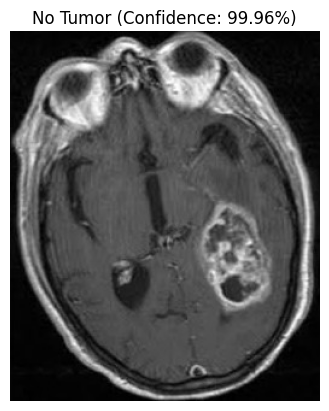

In [14]:
# Example usage
image_path = '/content/drive/MyDrive/BT_data/Testing/meningioma/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


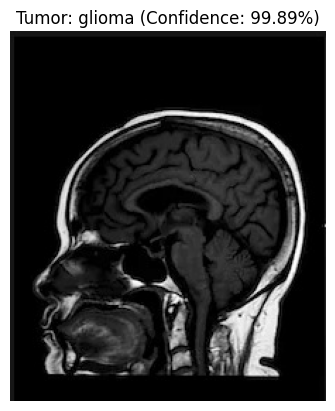

In [15]:
# Example usage
image_path = '/content/drive/MyDrive/BT_data/Testing/notumor/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)